We consider the one-dimensional linear advection equation:

$\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0, \quad x \in [0, 2\pi],\ t \in [0, 1]$

with advection speed:

$c = 10$

Initial Condition:

$u(x, 0) = \sin(x), \quad x \in [0, 2\pi]$

and periodic boundary condition

\begin{equation}
    u(0, t) = u(2\pi, t), \quad t \in [0, 1]
\end{equation}

# To do
Try different value of $C$ to see how the performance of PINN changes with respect to the true solution

In [2]:
import numpy as np
import matplotlib.pyplot as plt
c = 10.0                     # Advection speed
L = 2 * np.pi                # Domain lengthimport matplotlib.pyplot as plt
T = 1.0                      # Final time

# Numerical solution 

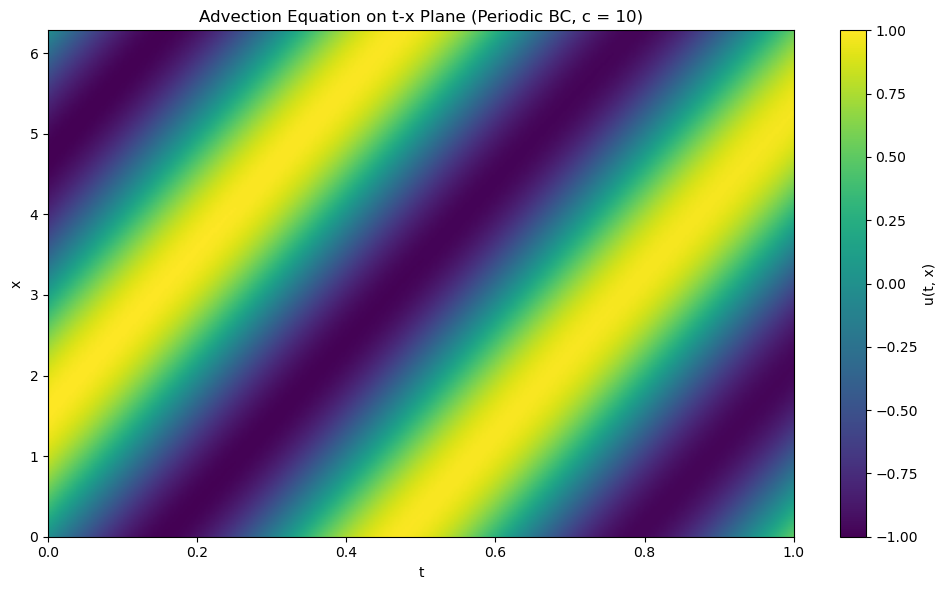

In [3]:


# Parameters

nx = 200                     # Number of spatial grid points
x = np.linspace(0, L, nx, endpoint=False)
dx = x[1] - x[0]

# CFL condition
lambda_cfl = 0.8             # CFL number < 1
dt = lambda_cfl * dx / c     # Time step based on CFL

nt = int(T / dt)             # Number of time steps
t = np.linspace(0, T, nt)

# Initial condition
u = np.sin(x)
u_xt = np.zeros((nt, nx))

# Time-stepping loop (Upwind + Periodic BC)
for n in range(nt):
    u_xt[n, :] = u
    u_new = u.copy()
    u_new[1:] = u[1:] - lambda_cfl * (u[1:] - u[:-1])
    u_new[0] = u[0] - lambda_cfl * (u[0] - u[-1])  # Periodic BC at x=0
    u = u_new

# Plot on t-x plane
plt.figure(figsize=(10, 6))
plt.imshow(u_xt.T, extent=[0, T, 0, L], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='u(t, x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Advection Equation on t-x Plane (Periodic BC, c = 10)')
plt.grid(False)
plt.tight_layout()
plt.show()


# PINN solution

/home/adil/.anaconda3/envs/ham/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/adil/.anaconda3/envs/ham/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 0.670487
Epoch 500, Loss: 0.299074
Epoch 1000, Loss: 0.117614
Epoch 1500, Loss: 0.072565
Epoch 2000, Loss: 0.046607
Epoch 2500, Loss: 0.012477
Epoch 3000, Loss: 0.002306
Epoch 3500, Loss: 0.000808
Epoch 4000, Loss: 0.000701
Epoch 4500, Loss: 0.000295
Training complete.


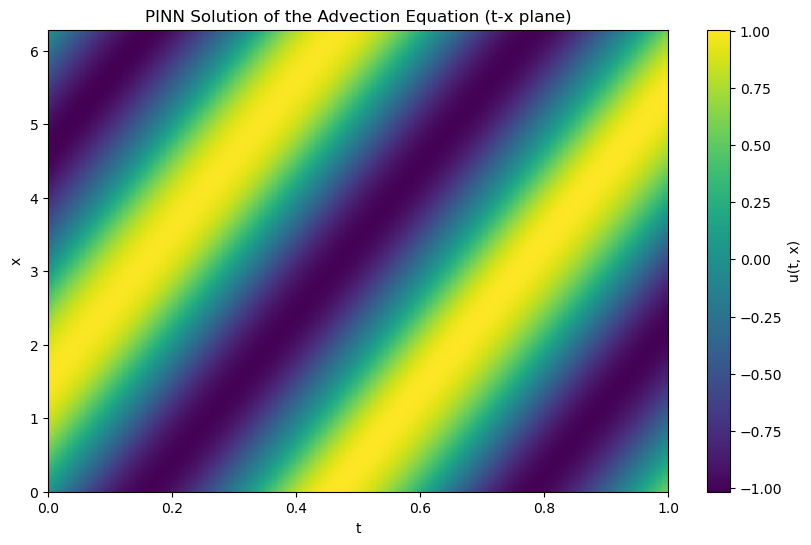

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        input = torch.cat([x, t], dim=1)
        return self.net(input)

# Create training data (collocation points)
def sampler(n_interior, n_initial, n_boundary):
    # Interior points
    x_int = np.random.uniform(0, L, (n_interior, 1))
    t_int = np.random.uniform(0, T, (n_interior, 1))

    # Initial condition points
    x_init = np.random.uniform(0, L, (n_initial, 1))
    t_init = np.zeros_like(x_init)

    # Boundary condition points (periodic)
    t_bc = np.random.uniform(0, T, (n_boundary, 1))
    x0 = np.zeros_like(t_bc)
    x1 = L * np.ones_like(t_bc)

    return (x_int, t_int), (x_init, t_init), (x0, x1, t_bc)

# Loss function
def loss_function(model, interior, initial, boundary):
    x_int, t_int = interior
    x_init, t_init = initial
    x0, x1, t_bc = boundary

    # Convert to tensors
    x_int = torch.tensor(x_int, dtype=torch.float32, requires_grad=True).to(device)
    t_int = torch.tensor(t_int, dtype=torch.float32, requires_grad=True).to(device)

    x_init = torch.tensor(x_init, dtype=torch.float32).to(device)
    t_init = torch.tensor(t_init, dtype=torch.float32).to(device)

    x0 = torch.tensor(x0, dtype=torch.float32).to(device)
    x1 = torch.tensor(x1, dtype=torch.float32).to(device)
    t_bc = torch.tensor(t_bc, dtype=torch.float32).to(device)

    # Interior loss (PDE residual)
    u = model(x_int, t_int)
    u_t = torch.autograd.grad(u, t_int, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_int, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    f = u_t + c * u_x
    loss_pde = torch.mean(f ** 2)

    # Initial condition loss
    u_init_pred = model(x_init, t_init)
    u_init_true = torch.sin(x_init)
    loss_ic = torch.mean((u_init_pred - u_init_true) ** 2)

    # Boundary (periodic) loss
    u0 = model(x0, t_bc)
    u1 = model(x1, t_bc)
    loss_bc = torch.mean((u0 - u1) ** 2)

    return loss_pde + loss_ic + loss_bc

# Training loop
def train(model, optimizer, n_epochs=5000):
    interior, initial, boundary = sampler(10000, 1000, 1000)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        loss = loss_function(model, interior, initial, boundary)
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    print("Training complete.")
    return model

# Instantiate and train
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model = train(model, optimizer, n_epochs=5000)

# Evaluate on grid
x_test = np.linspace(0, L, 200)
t_test = np.linspace(0, T, 100)
X, T_grid = np.meshgrid(x_test, t_test)
x_torch = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
t_torch = torch.tensor(T_grid.flatten(), dtype=torch.float32).unsqueeze(1).to(device)

with torch.no_grad():
    u_pred = model(x_torch, t_torch).cpu().numpy().reshape(T_grid.shape)

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(u_pred.T, extent=[0, T, 0, L], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='u(t, x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('PINN Solution of the Advection Equation (t-x plane)')
plt.show()


The linear advection equation describes transport of sharp features with no diffusion. However:

    PINNs minimize global residuals, which tends to:
        Favor smooth solutions that lower overall error
        "Blur" or "smooth out" traveling waves (instead of preserving sharp shifts)

    Even Fourier features, while better at learning oscillatory functions, struggle to track moving waves unless:
        The network is trained very carefully
        Or the network is specialized to represent transport behavior

Epoch 0, Loss: 2059.366943
Epoch 500, Loss: 0.749401
Epoch 1000, Loss: 0.573691
Epoch 1500, Loss: 0.525791
Epoch 2000, Loss: 0.504658
Epoch 2500, Loss: 0.493246
Epoch 3000, Loss: 0.486245
Epoch 3500, Loss: 0.482025
Epoch 4000, Loss: 0.529732
Epoch 4500, Loss: 0.588940
Training complete.


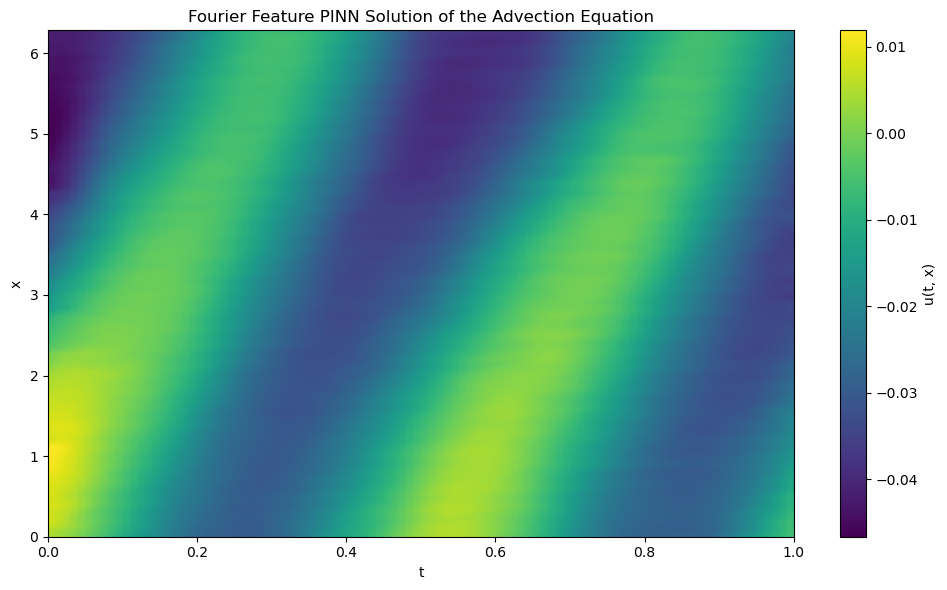

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set seeds
torch.manual_seed(0)
np.random.seed(0)

# Constants
c = 30.0
L = 2 * np.pi
T = 1.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Fourier Feature Encoding ====
class FourierFeatureEncoding(nn.Module):
    def __init__(self, in_features, num_frequencies=50):
        super().__init__()
        self.B = torch.randn((in_features, num_frequencies)) * 2.0
        self.B = self.B.to(device)

    def forward(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# ==== PINN with Fourier Features ====
class FourierPINN(nn.Module):
    def __init__(self, num_frequencies=50):
        super().__init__()
        self.ff = FourierFeatureEncoding(2, num_frequencies)
        self.net = nn.Sequential(
            nn.Linear(2 * num_frequencies, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, x, t):
        input = torch.cat([x, t], dim=1)
        ff_input = self.ff(input)
        return self.net(ff_input)

# ==== Sampling Function ====
def sampler(n_interior, n_initial, n_boundary):
    # Interior points
    x_int = np.random.uniform(0, L, (n_interior, 1))
    t_int = np.random.uniform(0, T, (n_interior, 1))

    # Initial condition points
    x_init = np.random.uniform(0, L, (n_initial, 1))
    t_init = np.zeros_like(x_init)

    # Periodic BC points
    t_bc = np.random.uniform(0, T, (n_boundary, 1))
    x0 = np.zeros_like(t_bc)
    x1 = L * np.ones_like(t_bc)

    return (x_int, t_int), (x_init, t_init), (x0, x1, t_bc)

# ==== Loss Function ====
def loss_function(model, interior, initial, boundary):
    x_int, t_int = interior
    x_init, t_init = initial
    x0, x1, t_bc = boundary

    x_int = torch.tensor(x_int, dtype=torch.float32, requires_grad=True).to(device)
    t_int = torch.tensor(t_int, dtype=torch.float32, requires_grad=True).to(device)

    x_init = torch.tensor(x_init, dtype=torch.float32).to(device)
    t_init = torch.tensor(t_init, dtype=torch.float32).to(device)

    x0 = torch.tensor(x0, dtype=torch.float32).to(device)
    x1 = torch.tensor(x1, dtype=torch.float32).to(device)
    t_bc = torch.tensor(t_bc, dtype=torch.float32).to(device)

    # PDE residual
    u = model(x_int, t_int)
    u_t = torch.autograd.grad(u, t_int, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_int, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    f = u_t + c * u_x
    loss_pde = torch.mean(f ** 2)

    # Initial condition
    u_init_pred = model(x_init, t_init)
    u_init_true = torch.sin(x_init)
    loss_ic = torch.mean((u_init_pred - u_init_true) ** 2)

    # Periodic boundary
    u0 = model(x0, t_bc)
    u1 = model(x1, t_bc)
    loss_bc = torch.mean((u0 - u1) ** 2)

    return loss_pde + loss_ic + loss_bc

# ==== Training Loop ====
def train(model, optimizer, n_epochs=5000):
    interior, initial, boundary = sampler(10000, 1000, 1000)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        loss = loss_function(model, interior, initial, boundary)
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    print("Training complete.")
    return model

# ==== Run Training ====
model = FourierPINN(num_frequencies=50).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, n_epochs=5000)

# ==== Evaluate on Grid ====
x_test = np.linspace(0, L, 200)
t_test = np.linspace(0, T, 100)
X, T_grid = np.meshgrid(x_test, t_test)
x_torch = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
t_torch = torch.tensor(T_grid.flatten(), dtype=torch.float32).unsqueeze(1).to(device)

with torch.no_grad():
    u_pred = model(x_torch, t_torch).cpu().numpy().reshape(T_grid.shape)

# ==== Plot ====
plt.figure(figsize=(10, 6))
plt.imshow(u_pred.T, extent=[0, T, 0, L], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='u(t, x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Fourier Feature PINN Solution of the Advection Equation')
plt.tight_layout()
plt.show()


2. Curriculum Training

Train only on the initial condition and boundary for the first few epochs. Then slowly include the PDE residual.

Idea Behind Curriculum Learning for PINNs

Instead of training the PINN to learn the PDE + initial + boundary conditions all at once, we break training into phases:

    Phase 1: Train only on initial and boundary conditions.
    This helps the network match the known behavior at t=0t=0 and ensure periodicity.

    Phase 2: Gradually introduce the PDE residual loss, giving it increasing weight.

In [6]:
def curriculum_train(model, optimizer, total_epochs=5000, transition_epoch=1000):
    """
    Phase 1: Fit IC and BC only
    Phase 2: Add PDE residual gradually
    """
    interior, initial, boundary = sampler(10000, 1000, 1000)

    for epoch in range(total_epochs):
        optimizer.zero_grad()

        # Prepare tensors
        x_int, t_int = interior
        x_init, t_init = initial
        x0, x1, t_bc = boundary

        x_int = torch.tensor(x_int, dtype=torch.float32, requires_grad=True).to(device)
        t_int = torch.tensor(t_int, dtype=torch.float32, requires_grad=True).to(device)
        x_init = torch.tensor(x_init, dtype=torch.float32).to(device)
        t_init = torch.tensor(t_init, dtype=torch.float32).to(device)
        x0 = torch.tensor(x0, dtype=torch.float32).to(device)
        x1 = torch.tensor(x1, dtype=torch.float32).to(device)
        t_bc = torch.tensor(t_bc, dtype=torch.float32).to(device)

        # Forward passes
        u = model(x_int, t_int)
        u_t = torch.autograd.grad(u, t_int, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x_int, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        f = u_t + c * u_x
        loss_pde = torch.mean(f ** 2)

        u_init_pred = model(x_init, t_init)
        u_init_true = torch.sin(x_init)
        loss_ic = torch.mean((u_init_pred - u_init_true) ** 2)

        u0 = model(x0, t_bc)
        u1 = model(x1, t_bc)
        loss_bc = torch.mean((u0 - u1) ** 2)

        # Curriculum: start without PDE residual
        if epoch < transition_epoch:
            total_loss = loss_ic + loss_bc
        else:
            # Weight PDE loss more as training progresses
            alpha = (epoch - transition_epoch) / (total_epochs - transition_epoch)
            total_loss = loss_ic + loss_bc + alpha * loss_pde

        total_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss.item():.6f}, PDE weight: {alpha if epoch >= transition_epoch else 0:.3f}")

    print("Training complete.")


In [7]:
# Initialize and train the model
model = FourierPINN(num_frequencies=50).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
curriculum_train(model, optimizer, total_epochs=5000, transition_epoch=1000)


Epoch 0, Loss: 0.533027, PDE weight: 0.000
Epoch 500, Loss: 0.000017, PDE weight: 0.000
Epoch 1000, Loss: 0.000015, PDE weight: 0.000
Epoch 1500, Loss: 0.415527, PDE weight: 0.125
Epoch 2000, Loss: 0.163051, PDE weight: 0.250
Epoch 2500, Loss: 0.154732, PDE weight: 0.375
Epoch 3000, Loss: 0.440510, PDE weight: 0.500
Epoch 3500, Loss: 0.123535, PDE weight: 0.625
Epoch 4000, Loss: 0.100704, PDE weight: 0.750
Epoch 4500, Loss: 0.091627, PDE weight: 0.875
Training complete.


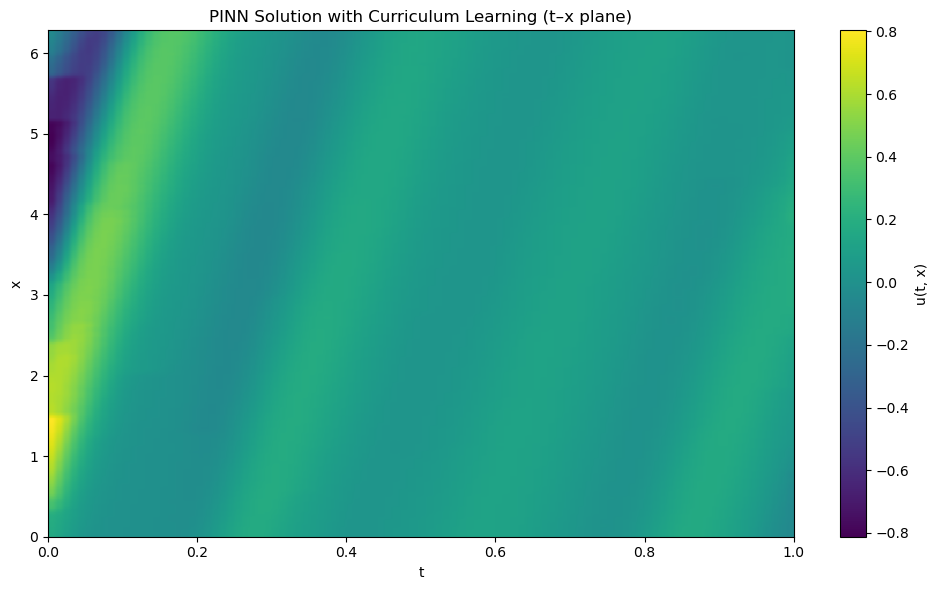

In [8]:
# ==== Evaluate the Trained Model ====
x_test = np.linspace(0, L, 200)
t_test = np.linspace(0, T, 100)
X, T_grid = np.meshgrid(x_test, t_test)

x_torch = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
t_torch = torch.tensor(T_grid.flatten(), dtype=torch.float32).unsqueeze(1).to(device)

with torch.no_grad():
    u_pred = model(x_torch, t_torch).cpu().numpy().reshape(T_grid.shape)

# ==== Plotting the Solution on t–x Plane ====
plt.figure(figsize=(10, 6))
plt.imshow(u_pred.T, extent=[0, T, 0, L], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='u(t, x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('PINN Solution with Curriculum Learning (t–x plane)')
plt.tight_layout()
plt.show()


What’s SIREN?

Instead of typical ReLU or Tanh activations, SIREN uses sine functions:
ϕ(x)=sin⁡(ω0x)
ϕ(x)=sin(ω0​x)

This makes it highly suitable for wave-like, periodic, and oscillatory problems like the advection equation.

Epoch 0, Loss: 8847.413086
Epoch 500, Loss: 0.610175
Epoch 1000, Loss: 0.536863
Epoch 1500, Loss: 0.464628
Epoch 2000, Loss: 0.422610
Epoch 2500, Loss: 1.954612
Epoch 3000, Loss: 0.908365
Epoch 3500, Loss: 0.303162
Epoch 4000, Loss: 0.408945
Epoch 4500, Loss: 0.322617
Training complete.


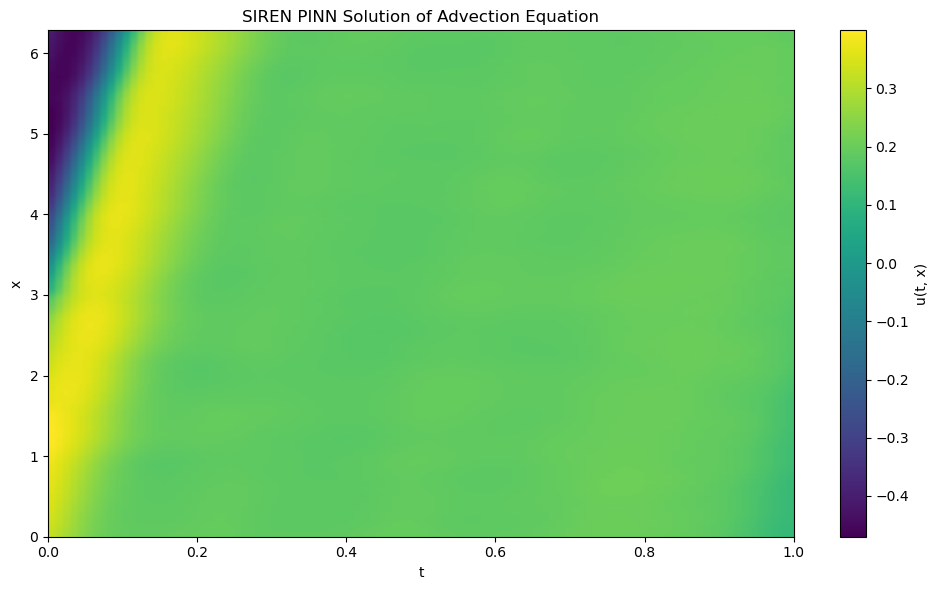

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Constants
c = 30.0
L = 2 * np.pi
T = 1.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)

# ==== SIREN Layer ====
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.linear = nn.Linear(in_features, out_features)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.linear.in_features,
                                             1 / self.linear.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.linear.in_features) / self.omega_0,
                                             np.sqrt(6 / self.linear.in_features) / self.omega_0)

    def forward(self, x):
        return torch.sin(self.omega_0 * self.linear(x))

# ==== SIREN Network ====
class SIRENPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            SineLayer(2, 64, is_first=True, omega_0=30),
            SineLayer(64, 64, omega_0=30),
            SineLayer(64, 64, omega_0=30),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

# ==== Sampling ====
def sampler(n_interior, n_initial, n_boundary):
    x_int = np.random.uniform(0, L, (n_interior, 1))
    t_int = np.random.uniform(0, T, (n_interior, 1))
    x_init = np.random.uniform(0, L, (n_initial, 1))
    t_init = np.zeros_like(x_init)
    t_bc = np.random.uniform(0, T, (n_boundary, 1))
    x0 = np.zeros_like(t_bc)
    x1 = L * np.ones_like(t_bc)
    return (x_int, t_int), (x_init, t_init), (x0, x1, t_bc)

# ==== Loss ====
def loss_function(model, interior, initial, boundary):
    x_int, t_int = interior
    x_init, t_init = initial
    x0, x1, t_bc = boundary

    x_int = torch.tensor(x_int, dtype=torch.float32, requires_grad=True).to(device)
    t_int = torch.tensor(t_int, dtype=torch.float32, requires_grad=True).to(device)
    x_init = torch.tensor(x_init, dtype=torch.float32).to(device)
    t_init = torch.tensor(t_init, dtype=torch.float32).to(device)
    x0 = torch.tensor(x0, dtype=torch.float32).to(device)
    x1 = torch.tensor(x1, dtype=torch.float32).to(device)
    t_bc = torch.tensor(t_bc, dtype=torch.float32).to(device)

    u = model(x_int, t_int)
    u_t = torch.autograd.grad(u, t_int, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_int, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    f = u_t + c * u_x
    loss_pde = torch.mean(f ** 2)

    u_init_pred = model(x_init, t_init)
    u_init_true = torch.sin(x_init)
    loss_ic = torch.mean((u_init_pred - u_init_true) ** 2)

    u0 = model(x0, t_bc)
    u1 = model(x1, t_bc)
    loss_bc = torch.mean((u0 - u1) ** 2)

    return loss_pde + loss_ic + loss_bc

# ==== Training ====
def train(model, optimizer, n_epochs=5000):
    interior, initial, boundary = sampler(10000, 1000, 1000)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        loss = loss_function(model, interior, initial, boundary)
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    print("Training complete.")

# ==== Train and Evaluate ====
model = SIRENPINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, n_epochs=5000)

# ==== Evaluate on Grid ====
x_test = np.linspace(0, L, 200)
t_test = np.linspace(0, T, 100)
X, T_grid = np.meshgrid(x_test, t_test)

x_torch = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
t_torch = torch.tensor(T_grid.flatten(), dtype=torch.float32).unsqueeze(1).to(device)

with torch.no_grad():
    u_pred = model(x_torch, t_torch).cpu().numpy().reshape(T_grid.shape)

# ==== Plot ====
plt.figure(figsize=(10, 6))
plt.imshow(u_pred.T, extent=[0, T, 0, L], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='u(t, x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('SIREN PINN Solution of Advection Equation')
plt.tight_layout()
plt.show()


# NN + PINN

Epoch    0 | Loss: 29.119528
Epoch  300 | Loss: 4.465482
Epoch  600 | Loss: 4.468020
Epoch  900 | Loss: 4.950836
Epoch 1200 | Loss: 4.396194
Epoch 1500 | Loss: 4.467645
Epoch 1800 | Loss: 4.399817
Epoch 2100 | Loss: 4.393735
Epoch 2400 | Loss: 4.347318
Epoch 2700 | Loss: 4.390567


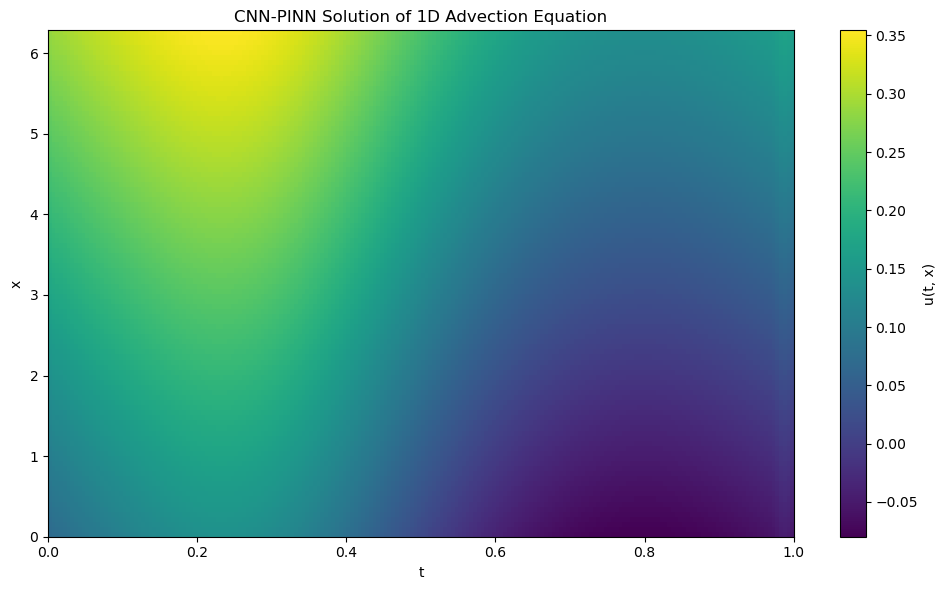

: 

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ========== Setup ==========
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Problem parameters
c = 10.0
L = 2 * np.pi
T = 1.0
N_GRID = 200  # number of spatial grid points

# ========== Spatial CNN Encoder ==========
class SpatialEncoder(nn.Module):
    def __init__(self, N):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),
            nn.Tanh(),
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.Tanh(),
            nn.Conv1d(32, 1, kernel_size=5, padding=2)
        )
        self.x_grid = torch.linspace(0, L, N).view(1, 1, -1).to(device)

    def forward(self, x_query, features):
        xq = x_query.view(-1, 1)
        xq_norm = xq / L * (features.shape[-1] - 1)
        x0 = torch.floor(xq_norm)
        x1 = x0 + 1

        x0_idx = torch.clamp(x0, 0, features.shape[-1] - 1)
        x1_idx = torch.clamp(x1, 0, features.shape[-1] - 1)

        x0_w = (x1 - xq_norm)
        x1_w = (xq_norm - x0)

        x0_idx = x0_idx.long()
        x1_idx = x1_idx.long()

        f0 = features[0, 0, x0_idx.view(-1)]
        f1 = features[0, 0, x1_idx.view(-1)]

        return (x0_w.view(-1) * f0 + x1_w.view(-1) * f1).view(-1, 1)

# ========== CNN-PINN Model ==========
class CNNPINN(nn.Module):
    def __init__(self, N):
        super().__init__()
        self.encoder = SpatialEncoder(N)
        self.time_net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        x, t = x.to(device), t.to(device)
        spatial_features = self.encoder.conv(self.encoder.x_grid)  # (1, 1, N)
        u_x = self.encoder(x, spatial_features)  # (B, 1)
        u_t = self.time_net(t)                   # (B, 1)
        return u_x + u_t                         # (B, 1)

# ========== Loss Functions ==========
def sample_collocation(n):
    x = torch.FloatTensor(n, 1).uniform_(0, L)
    t = torch.FloatTensor(n, 1).uniform_(0, T)
    return x, t

def pde_loss(model, x, t):
    x = x.to(device).requires_grad_()
    t = t.to(device).requires_grad_()
    u = model(x, t)
    du_dt = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    return torch.mean((du_dt + c * du_dx) ** 2)

def ic_loss(model, x_grid):
    x0 = x_grid.to(device)
    t0 = torch.zeros_like(x0).to(device)
    u_pred = model(x0, t0)
    u_true = torch.sin(x0)
    return torch.mean((u_pred - u_true)**2)

def bc_loss(model):
    t = torch.linspace(0, T, 100).unsqueeze(1).to(device)
    x0 = torch.zeros_like(t)
    x1 = torch.full_like(t, L)
    return torch.mean((model(x0, t) - model(x1, t)) ** 2)

# ========== Training ==========
def train(model, optimizer, x_grid, epochs=3000):
    for epoch in range(epochs):
        x_col, t_col = sample_collocation(1024)
        loss = (
            pde_loss(model, x_col, t_col)
            + 10 * ic_loss(model, x_grid)
            + 10 * bc_loss(model)
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 300 == 0:
            print(f"Epoch {epoch:4d} | Loss: {loss.item():.6f}")

# ========== Run Training ==========
x_grid = torch.linspace(0, L, N_GRID).unsqueeze(1)
model = CNNPINN(N_GRID).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, x_grid)

# ========== Evaluation and Plot ==========
x_eval = torch.linspace(0, L, N_GRID).unsqueeze(1).to(device)
t_eval = torch.linspace(0, T, 100).unsqueeze(1).to(device)
X, T_grid = torch.meshgrid(x_eval.squeeze(), t_eval.squeeze(), indexing='ij')
u_pred = torch.zeros_like(X).cpu()

with torch.no_grad():
    for j in range(t_eval.shape[0]):
        u_pred[:, j] = model(x_eval, t_eval[j].repeat(x_eval.shape[0], 1)).cpu().squeeze()

plt.figure(figsize=(10, 6))
plt.imshow(u_pred.T, extent=[0, T, 0, L], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='u(t, x)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('CNN-PINN Solution of 1D Advection Equation')
plt.tight_layout()
plt.show()
